# Building an Interpretable Expected Goals (xG) Model
* Author: Oliver Mueller
* Date: 2024-02-15

In [1]:
import warnings
warnings.filterwarnings("ignore")

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsbombpy import sb
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.metrics import classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Load data

Using the `statsbombpy` package, we will query the StatsBomb API for all events of the Bundesliga season 2015/16.  

In [ ]:
grouped_events = sb.competition_events(
    country="Germany",
    division= "1. Bundesliga",
    season="2015/2016",
    gender="male",
    split=True
)

What types of events do we have?

In [ ]:
grouped_events.keys()

Extract and explore the shots.

In [ ]:
shots = grouped_events["shots"]

In [ ]:
shots.shape

In [ ]:
shots.head()

In [ ]:
shots.columns

In [ ]:
shots.iloc[0]

In [ ]:
shots.iloc[0]["shot_freeze_frame"]

In [ ]:
shots["shot_outcome"].value_counts()

Save/load shots object to/from disk.

In [2]:
#shots.to_pickle("data/shots.pkl")
shots = pd.read_pickle("data/shots.pkl")

## Train classifier

Construct the label.

In [3]:
shots["is_goal"] = shots["shot_outcome"].apply(lambda x: 1 if x == "Goal" else 0)

Engineer some features.

In [4]:
shots["location_x"] = shots["location"].apply(lambda x: float(x[0]))
shots["location_y"] = shots["location"].apply(lambda x: float(x[1]))

In [5]:
shots["distance_to_goal"] = shots.apply(lambda row: math.dist(row["location"], [120.0, 40.0]), axis=1)

In [6]:
def angle_between_points(P, Q1, Q2):
    # Calculate vectors from P to Q1 and Q2
    vector_PQ1 = (Q1[0] - P[0], Q1[1] - P[1])
    vector_PQ2 = (Q2[0] - P[0], Q2[1] - P[1])
    
    # Calculate dot product
    dot_product = vector_PQ1[0] * vector_PQ2[0] + vector_PQ1[1] * vector_PQ2[1]
    
    # Calculate magnitudes of vectors
    magnitude_PQ1 = math.sqrt(vector_PQ1[0] ** 2 + vector_PQ1[1] ** 2)
    magnitude_PQ2 = math.sqrt(vector_PQ2[0] ** 2 + vector_PQ2[1] ** 2)
    
    # Calculate angle in radians
    angle_radians = math.acos(dot_product / (magnitude_PQ1 * magnitude_PQ2))
    
    # Convert angle to degrees
    angle_degrees = math.degrees(angle_radians)
    
    return angle_degrees

In [7]:
shots["angle_to_goal"] = shots.apply(lambda row: angle_between_points(row["location"], [120.0, 36.0], [120.0, 44.0]), axis=1)

In [8]:
shots.iloc[0]

id                                    ba46e9d6-e828-4599-952c-39c1f7d22659
index                                                                  263
period                                                                   1
timestamp                                                     00:04:21.052
minute                                                                   4
second                                                                  21
type                                                                  Shot
possession                                                               7
possession_team                                                 Hoffenheim
play_pattern                                                  Regular Play
team                                                            Hoffenheim
player                                                   Tarik Elyounoussi
position                                                    Left Wing Back
location                 

Make a train-test split.

In [9]:
train, test = train_test_split(shots, test_size=0.2, random_state=42)

Train a logistic regression model.

In [10]:
model_logit = smf.logit(formula='is_goal ~ location_x + location_y + distance_to_goal + angle_to_goal', data=train)
model_logit = model_logit.fit()

Optimization terminated successfully.
         Current function value: 0.298755
         Iterations 8


In [11]:
print(model_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                is_goal   No. Observations:                 6264
Model:                          Logit   Df Residuals:                     6259
Method:                           MLE   Df Model:                            4
Date:                Fri, 16 Feb 2024   Pseudo R-squ.:                  0.1242
Time:                        19:36:26   Log-Likelihood:                -1871.4
converged:                       True   LL-Null:                       -2136.8
Covariance Type:            nonrobust   LLR p-value:                1.428e-113
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.9268      2.839      1.736      0.083      -0.637      10.491
location_x          -0.0516      0.022     -2.332      0.020      -0.095      -0.008
location_y           0.0066 

Evaluate the model.

In [12]:
pred_proba = model_logit.predict(test)

In [13]:
roc_auc_score(test["is_goal"], pred_proba)

0.7553196112859204

## Visualize model

We create a 2D grid of x/y pitch coordinates from (0, 0) to (120, 80). We also calculate distance and angle to the goal for each cell.

In [14]:
simulated_positions = pd.DataFrame()
simulated_positions["location_x"] = np.tile(np.arange(0, 121, 1), 81)
simulated_positions["location_y"] = np.repeat(np.arange(0, 81, 1), 121)
simulated_positions["distance_to_goal"] = simulated_positions.apply(lambda row: math.dist([row["location_x"], row["location_y"]], [120.0, 40.0]), axis=1)
simulated_positions["angle_to_goal"] = simulated_positions.apply(lambda row: angle_between_points([row["location_x"], row["location_y"]], [120.0, 36.0], [120.0, 44.0]), axis=1)

In [15]:
simulated_positions.head()

,location_x,location_y,distance_to_goal,angle_to_goal
0,0,0,126.491106,3.437059
1,1,0,125.542821,3.460099
2,2,0,124.595345,3.483400
3,3,0,123.648696,3.506964
4,4,0,122.702893,3.530795


In [16]:
simulated_positions.tail()

,location_x,location_y,distance_to_goal,angle_to_goal
9796,116,80,40.199502,1.145763
9797,117,80,40.112342,0.863148
9798,118,80,40.049969,0.577268
9799,119,80,40.012498,0.289188
9800,120,80,40.000000,0.000000


In [17]:
simulated_positions[(simulated_positions["location_x"] == 109) & (simulated_positions["location_y"] == 40)]

,location_x,location_y,distance_to_goal,angle_to_goal
4949,109,40,11.0,39.966213


We predict the probability of a goal for each test observation.

In [18]:
pred_proba = model_logit.predict(simulated_positions)
simulated_positions["xG"] = pred_proba

In [19]:
simulated_positions.head()

,location_x,location_y,distance_to_goal,angle_to_goal,xG
0,0,0,126.491106,3.437059,0.000002
1,1,0,125.542821,3.460099,0.000002
2,2,0,124.595345,3.483400,0.000002
3,3,0,123.648696,3.506964,0.000002
4,4,0,122.702893,3.530795,0.000002


The highlight is a visualization of our xG model.

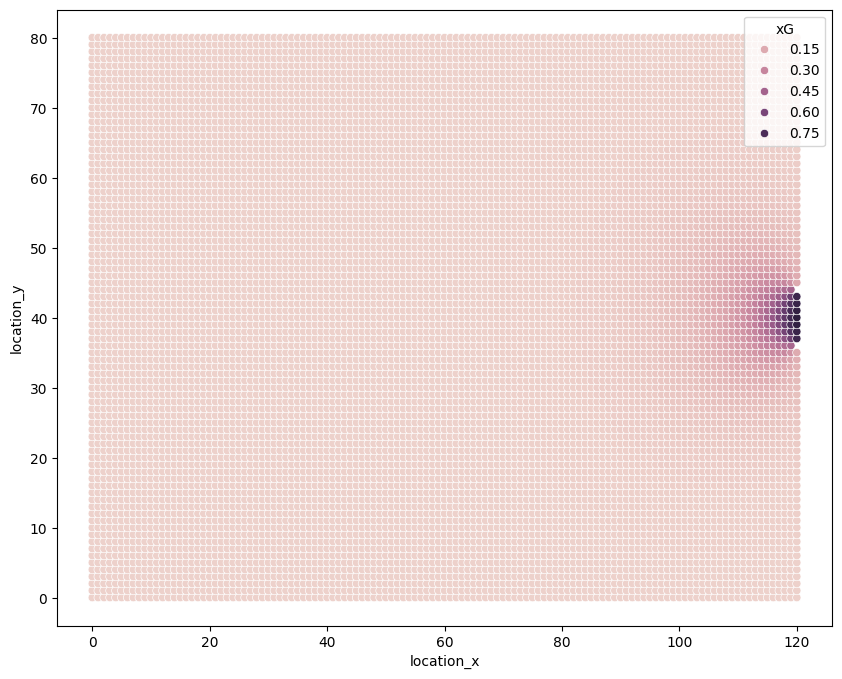

In [20]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=simulated_positions, x="location_x", y="location_y", hue="xG")
plt.show()
